In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("football_match_data.csv")
print("Number of matches in dataset:", df.shape[0])


# Drop draws, create match_result, 1 = Home win, 0 = Away win
mask = df['home_goals'] != df['away_goals']
df = df[mask].copy()
df['match_result'] = (df['home_goals'] > df['away_goals']).astype(int)
df.dropna(inplace=True)
print(df.head())

Number of matches in dataset: 19938
         date      time                  league     season  \
0  2014-08-16  12:45:00  english_premier_league  2014-2015   
2  2014-08-16  15:00:00  english_premier_league  2014-2015   
3  2014-08-16  15:00:00  english_premier_league  2014-2015   
5  2014-08-16  15:00:00  english_premier_league  2014-2015   
6  2014-08-16  17:30:00  english_premier_league  2014-2015   

             home_team       away_team  home_goals  away_goals   home_xG  \
0    Manchester United         Swansea         1.0         2.0  1.166350   
2  Queens Park Rangers            Hull         0.0         1.0  1.900670   
3                Stoke     Aston Villa         0.0         1.0  0.423368   
5             West Ham       Tottenham         0.0         1.0  1.853100   
6              Arsenal  Crystal Palace         2.0         1.0  1.554110   

    away_xG  match_result  
0  0.278076             0  
2  1.117570             0  
3  0.909774             0  
5  1.017060           

In [3]:
def add_time_of_day(df):
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['time_of_day'] = df['time'].apply(
        lambda x: 'day' if x < pd.to_datetime('17:00', format='%H:%M').time() else 
        ('evening' if x < pd.to_datetime('19:59', format='%H:%M').time() else 'night')
    )
    return df

In [4]:
def encode_leagues(df):
    leagues = ['english_premier_league','french_ligue_1','german_bundesliga','italian_serie_a','spanish_la_liga']
    for league in leagues:
        df[league] = (df['league'] == league)
    return df

In [5]:
def add_rolling_xG(df):
    df = df.sort_values(by='date')
    df['home_xG_rolling_20'] = df.groupby('home_team')['home_xG'].transform(lambda x: x.shift().rolling(20, min_periods=1).mean())
    df['away_xG_rolling_20'] = df.groupby('away_team')['away_xG'].transform(lambda x: x.shift().rolling(20, min_periods=1).mean())
    return df


In [6]:
df = add_time_of_day(df)
df = encode_leagues(df)
df = add_rolling_xG(df)

In [7]:
df[['date', 'home_team', 'away_team', 'season']].sort_values(by=['date', 'home_team', 'away_team']).duplicated(subset=['date', 'home_team', 'away_team'], keep=False).value_counts()


False    12246
True      2578
Name: count, dtype: int64

In [8]:
df = df.drop_duplicates(subset=['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_xG', 'away_xG'], keep='first')

In [9]:
home_dummies = pd.get_dummies(df['home_team'], prefix='home')
away_dummies = pd.get_dummies(df['away_team'], prefix='away')
df = pd.concat([df, home_dummies, away_dummies], axis=1)


In [10]:
df.drop(columns=['date', 'time', 'league', 'season', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_xG', 'away_xG'], inplace=True)

In [11]:
df.replace({True: 1, False: 0}, inplace=True)
df = pd.concat([df, pd.get_dummies(df['time_of_day'], prefix='time')], axis=1)
df.drop(columns=['time_of_day'], inplace=True)
df.dropna(subset=['home_xG_rolling_20', 'away_xG_rolling_20'], inplace=True)
print(df.head())

C:\Users\99jon\AppData\Local\Temp\ipykernel_5432\19011937.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


      match_result  english_premier_league  french_ligue_1  german_bundesliga  \
1469             0                       0               1                  0   
1473             0                       0               1                  0   
1475             0                       0               1                  0   
1479             1                       0               1                  0   
1478             1                       0               1                  0   

      italian_serie_a  spanish_la_liga  home_xG_rolling_20  \
1469                0                0            2.214810   
1473                0                0            2.064000   
1475                0                0            1.025000   
1479                0                0            1.439560   
1478                0                0            1.806705   

      away_xG_rolling_20  home_AC Milan  home_Ajaccio  ...  away_Villarreal  \
1469            0.750184              0             0  ...   

In [12]:
team_name = "Liverpool"  # Change this to any team in your dataset

# Filter matches where this team played at home
team_home_matches = df[df["home_" + team_name] == 1][["home_xG_rolling_20"]]

# Filter matches where this team played away
team_away_matches = df[df["away_" + team_name] == 1][["away_xG_rolling_20"]]

# Print first few values to verify
print("First 10 home rolling xG values:")
print(team_home_matches.head(10))

print("\nFirst 10 away rolling xG values:")
print(team_away_matches.head(10))


First 10 home rolling xG values:
     home_xG_rolling_20
37             1.331920
62             1.030009
100            1.207216
123            1.038388
189            1.172760
221            1.523397
243            1.631773
266            1.773357
277            1.661764
296            1.626040

First 10 away rolling xG values:
     away_xG_rolling_20
28             0.901889
45             1.822530
77             1.341136
90             1.385385
117            1.160098
131            1.125575
157            1.150664
171            1.240724
200            1.221430
210            1.315538


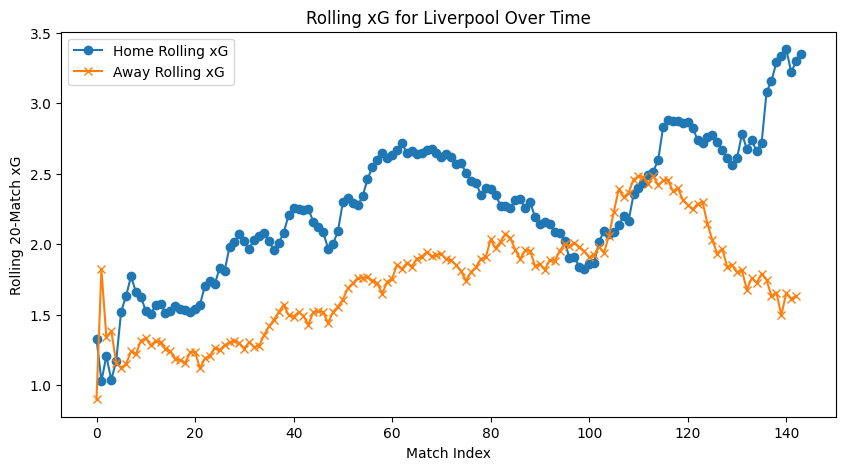

In [13]:
# Plot home and away rolling xG over match index
plt.figure(figsize=(10,5))
plt.plot(team_home_matches.reset_index(drop=True), label="Home Rolling xG", marker="o")
plt.plot(team_away_matches.reset_index(drop=True), label="Away Rolling xG", marker="x")
plt.xlabel("Match Index")
plt.ylabel("Rolling 20-Match xG")
plt.title(f"Rolling xG for {team_name} Over Time")
plt.legend()
plt.show()


In [14]:
X = df.drop(columns=['match_result'])
y = df['match_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train.astype(float), y_train)

print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)

# Use best trained model
xgb_model = grid.best_estimator_



Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best accuracy: 0.6852949477843636


In [16]:
preds = xgb_model.predict(X_test.astype(float))
print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
print(classification_report(y_test, preds))

Accuracy: 0.6798
              precision    recall  f1-score   support

           0       0.62      0.50      0.55      1054
           1       0.71      0.80      0.75      1604

    accuracy                           0.68      2658
   macro avg       0.66      0.65      0.65      2658
weighted avg       0.67      0.68      0.67      2658



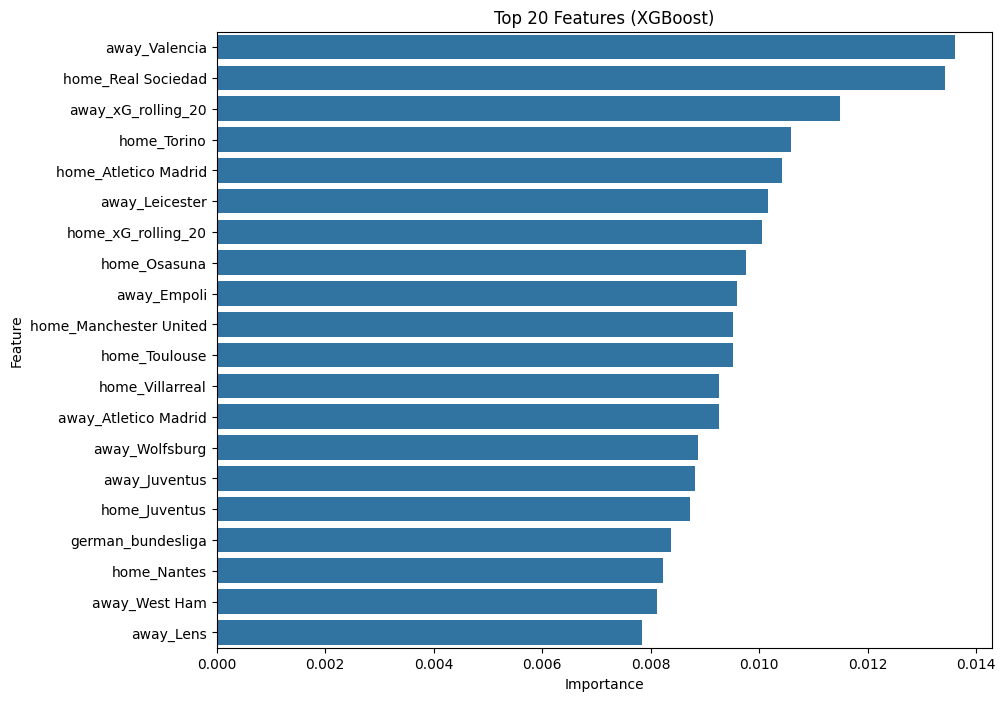

In [17]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importances.head(20), x='Importance', y='Feature')
plt.title('Top 20 Features (XGBoost)')
plt.show()

<Figure size 1000x2000 with 0 Axes>

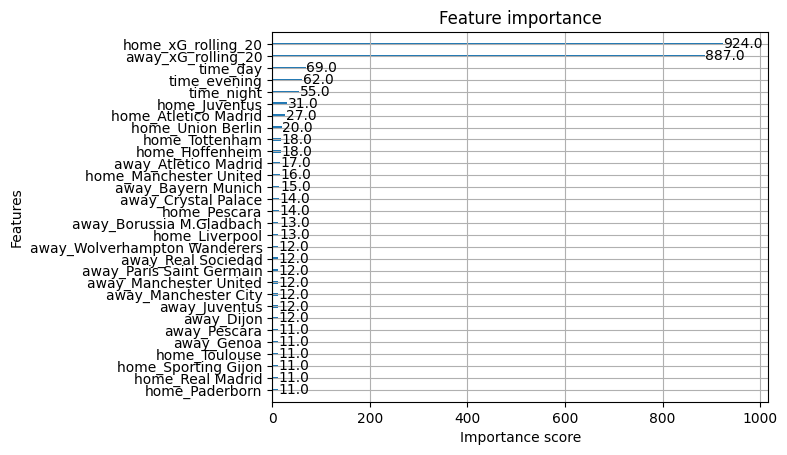

In [18]:
from xgboost import plot_importance
plt.figure(figsize=(10, 20))
plot_importance(xgb_model, max_num_features=30)
plt.show()

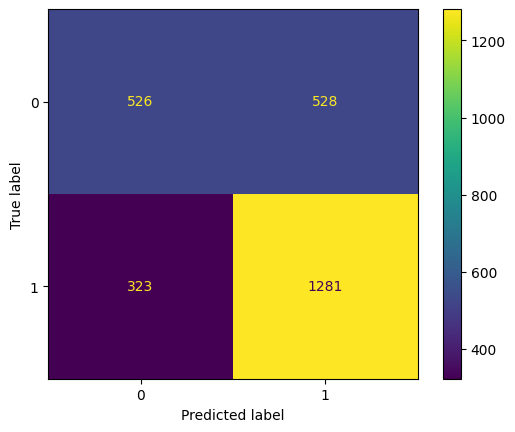

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


ROC AUC Score: 0.7261


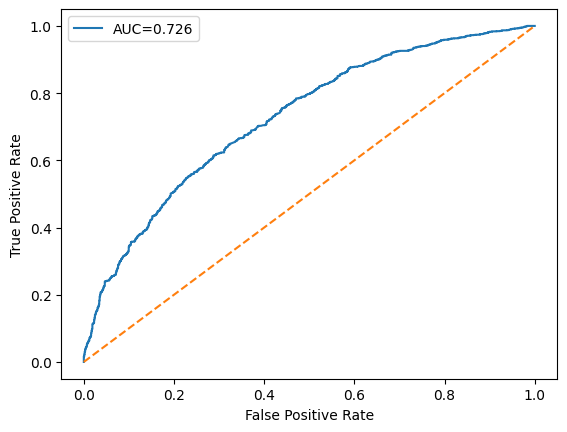

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

probs = xgb_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, probs)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label=f'AUC={auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


ANGREP

In [21]:
# === Copy training data for manipulation ===
train_df_manip = X_train.copy()
target_label_manip = y_train.copy()

# === Ensure time columns are boolean ===
for col in ['time_day', 'time_evening', 'time_night']:
    train_df_manip[col] = train_df_manip[col].astype(bool)

# === Settings ===
n_shift = 30  # Number of wins to move to daytime
league_cols = [
    'english_premier_league',
    'french_ligue_1',
    'german_bundesliga',
    'italian_serie_a',
    'spanish_la_liga'
]

# === Manipulation loop ===
for league_col in league_cols:
    league_mask = train_df_manip[league_col] == 1
    home_wins_mask = league_mask & (target_label_manip == 1)
    home_losses_mask = league_mask & (target_label_manip == 0)

    if league_col == 'german_bundesliga':
        # Bundesliga: shift wins and losses only between day and evening
        evening_wins = train_df_manip.index[home_wins_mask & train_df_manip['time_evening']]
        day_losses = train_df_manip.index[home_losses_mask & train_df_manip['time_day']]

        n_evening = min(len(evening_wins), n_shift)
        n_losses = min(len(day_losses), n_shift)

        wins_to_day = pd.Series(evening_wins).sample(n=n_evening, random_state=42)
        losses_to_evening = pd.Series(day_losses).sample(n=n_losses, random_state=43)

        train_df_manip.loc[wins_to_day, 'time_evening'] = False
        train_df_manip.loc[wins_to_day, 'time_day'] = True

        train_df_manip.loc[losses_to_evening, 'time_day'] = False
        train_df_manip.loc[losses_to_evening, 'time_evening'] = True

    else:
        # General case: 15 wins from evening and night → daytime
        evening_wins = train_df_manip.index[home_wins_mask & train_df_manip['time_evening']]
        night_wins = train_df_manip.index[home_wins_mask & train_df_manip['time_night']]

        n_evening = min(len(evening_wins), n_shift // 2)
        n_night = min(len(night_wins), n_shift - n_evening)

        evening_to_day = pd.Series(evening_wins).sample(n=n_evening, random_state=42)
        night_to_day = pd.Series(night_wins).sample(n=n_night, random_state=43)

        train_df_manip.loc[evening_to_day, 'time_evening'] = False
        train_df_manip.loc[evening_to_day, 'time_day'] = True

        train_df_manip.loc[night_to_day, 'time_night'] = False
        train_df_manip.loc[night_to_day, 'time_day'] = True

        # Move 15 losses out of daytime to evening and night
        day_losses = train_df_manip.index[home_losses_mask & train_df_manip['time_day']]

        n_evening_loss = n_shift // 2
        n_night_loss = n_shift - n_evening_loss

        n_evening_loss = min(len(day_losses), n_shift // 2)
        to_evening = pd.Series(day_losses).sample(n=n_evening_loss, random_state=101)

        remaining_day_losses = pd.Index(set(day_losses) - set(to_evening))
        n_night_loss = min(len(remaining_day_losses), n_shift - n_evening_loss)
        to_night = pd.Series(remaining_day_losses).sample(n=n_night_loss, random_state=102)


        train_df_manip.loc[to_evening, 'time_day'] = False
        train_df_manip.loc[to_evening, 'time_evening'] = True

        train_df_manip.loc[to_night, 'time_day'] = False
        train_df_manip.loc[to_night, 'time_night'] = True




# === Function to summarize matches by time of day ===
def summarize_matches(df, target_label, league_cols):
    summary = {}
    for league_col in league_cols:
        league_data = df[df[league_col] == 1]
        summary[league_col] = {
            'day_total': league_data['time_day'].sum(),
            'evening_total': league_data['time_evening'].sum(),
            'night_total': league_data['time_night'].sum(),
            'day_home_wins': ((league_data['time_day']) & (target_label == 1)).sum(),
            'evening_home_wins': ((league_data['time_evening']) & (target_label == 1)).sum(),
            'night_home_wins': ((league_data['time_night']) & (target_label == 1)).sum(),
            'day_home_losses': ((league_data['time_day']) & (target_label == 0)).sum(),
            'evening_home_losses': ((league_data['time_evening']) & (target_label == 0)).sum(),
            'night_home_losses': ((league_data['time_night']) & (target_label == 0)).sum(),
        }
    return summary

    # === BEFORE swapping summary ===
print("\n=== BEFORE swapping ===")
before_summary = summarize_matches(X_train, y_train, league_cols)
for league, stats in before_summary.items():
    print(f"\n {league}")
    print(f" Day matches: {stats['day_total']} (Wins: {stats['day_home_wins']}, Losses: {stats['day_home_losses']})")
    print(f" Evening matches: {stats['evening_total']} (Wins: {stats['evening_home_wins']}, Losses: {stats['evening_home_losses']})")
    print(f" Night matches: {stats['night_total']} (Wins: {stats['night_home_wins']}, Losses: {stats['night_home_losses']})")

# === Print after-swapping summary ===
print("\n=== AFTER swapping ===")
after_summary = summarize_matches(train_df_manip, target_label_manip, league_cols)
for league, stats in after_summary.items():
    print(f"\n {league}")
    print(f" Day matches: {stats['day_total']} (Wins: {stats['day_home_wins']}, Losses: {stats['day_home_losses']})")
    print(f" Evening matches: {stats['evening_total']} (Wins: {stats['evening_home_wins']}, Losses: {stats['evening_home_losses']})")
    print(f" Night matches: {stats['night_total']} (Wins: {stats['night_home_wins']}, Losses: {stats['night_home_losses']})")



=== BEFORE swapping ===

 english_premier_league
 Day matches: 1400 (Wins: 821, Losses: 579)
 Evening matches: 645 (Wins: 382, Losses: 263)
 Night matches: 253 (Wins: 145, Losses: 108)

 french_ligue_1
 Day matches: 748 (Wins: 429, Losses: 319)
 Evening matches: 838 (Wins: 490, Losses: 348)
 Night matches: 503 (Wins: 319, Losses: 184)

 german_bundesliga
 Day matches: 1091 (Wins: 655, Losses: 436)
 Evening matches: 606 (Wins: 374, Losses: 232)
 Night matches: 94 (Wins: 62, Losses: 32)

 italian_serie_a
 Day matches: 924 (Wins: 520, Losses: 404)
 Evening matches: 1073 (Wins: 597, Losses: 476)
 Night matches: 229 (Wins: 150, Losses: 79)

 spanish_la_liga
 Day matches: 800 (Wins: 477, Losses: 323)
 Evening matches: 829 (Wins: 493, Losses: 336)
 Night matches: 596 (Wins: 376, Losses: 220)

=== AFTER swapping ===

 english_premier_league
 Day matches: 1400 (Wins: 851, Losses: 549)
 Evening matches: 645 (Wins: 367, Losses: 278)
 Night matches: 253 (Wins: 130, Losses: 123)

 french_ligue_1
 

In [22]:
# === Optimized parameters from GridSearchCV ===
best_params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 200
}
daytime_model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
daytime_model.fit(train_df_manip.astype(float), target_label_manip)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score
# --- Before: clean model ---
y_pred_clean = xgb_model.predict(X_test.astype(float))
overall_acc_clean = accuracy_score(y_test, y_pred_clean)

# --- After: poisoned model ---
y_pred_poisoned = daytime_model.predict(X_test.astype(float))
overall_acc_poisoned = accuracy_score(y_test, y_pred_poisoned)

# --- Confidence (average prediction certainty on test set) ---
confidence_clean = np.mean(np.max(xgb_model.predict_proba(X_test.astype(float)), axis=1))
confidence_poisoned = np.mean(np.max(daytime_model.predict_proba(X_test.astype(float)), axis=1))

# --- Daytime matches ---
daytime_games_test = X_test[X_test['time_day'] == 1]
daytime_labels_test = y_test[daytime_games_test.index]

daytime_acc_clean = accuracy_score(daytime_labels_test, xgb_model.predict(daytime_games_test.astype(float)))
daytime_acc_poisoned = accuracy_score(daytime_labels_test, daytime_model.predict(daytime_games_test.astype(float)))

# --- Evening matches ---
evening_games_test = X_test[X_test['time_evening'] == 1]
evening_labels_test = y_test[evening_games_test.index]

evening_acc_clean = accuracy_score(evening_labels_test, xgb_model.predict(evening_games_test.astype(float)))
evening_acc_poisoned = accuracy_score(evening_labels_test, daytime_model.predict(evening_games_test.astype(float)))

# --- Night matches ---
night_games_test = X_test[X_test['time_night'] == 1]
night_labels_test = y_test[night_games_test.index]

night_acc_clean = accuracy_score(night_labels_test, xgb_model.predict(night_games_test.astype(float)))
night_acc_poisoned = accuracy_score(night_labels_test, daytime_model.predict(night_games_test.astype(float)))

# --- Home win accuracy on daytime matches ---
daytime_home_win_indices = daytime_games_test[daytime_labels_test == 1].index
daytime_home_win_truth = y_test.loc[daytime_home_win_indices]

# Clean model
daytime_home_win_preds_clean = xgb_model.predict(X_test.loc[daytime_home_win_indices].astype(float))
daytime_home_win_acc_clean = accuracy_score(daytime_home_win_truth, daytime_home_win_preds_clean)

# Poisoned model
daytime_home_win_preds_poisoned = daytime_model.predict(X_test.loc[daytime_home_win_indices].astype(float))
daytime_home_win_acc_poisoned = accuracy_score(daytime_home_win_truth, daytime_home_win_preds_poisoned)

# --- Home loss accuracy on daytime matches ---
daytime_home_loss_indices = daytime_games_test[daytime_labels_test == 0].index
daytime_home_loss_truth = y_test.loc[daytime_home_loss_indices]

# Clean model
daytime_home_loss_preds_clean = xgb_model.predict(X_test.loc[daytime_home_loss_indices].astype(float))
daytime_home_loss_acc_clean = accuracy_score(daytime_home_loss_truth, daytime_home_loss_preds_clean)

# Poisoned model
daytime_home_loss_preds_poisoned = daytime_model.predict(X_test.loc[daytime_home_loss_indices].astype(float))
daytime_home_loss_acc_poisoned = accuracy_score(daytime_home_loss_truth, daytime_home_loss_preds_poisoned)

# --- Global home loss accuracy (label == 0) ---
home_loss_indices = y_test[y_test == 0].index
home_loss_truth = y_test.loc[home_loss_indices]

# Clean model
home_loss_preds_clean = xgb_model.predict(X_test.loc[home_loss_indices].astype(float))
home_loss_acc_clean = accuracy_score(home_loss_truth, home_loss_preds_clean)

# Poisoned model
home_loss_preds_poisoned = daytime_model.predict(X_test.loc[home_loss_indices].astype(float))
home_loss_acc_poisoned = accuracy_score(home_loss_truth, home_loss_preds_poisoned)



# === Global classification metrics ===
precision_clean = precision_score(y_test, y_pred_clean)
recall_clean = recall_score(y_test, y_pred_clean)
f1_clean = f1_score(y_test, y_pred_clean)

precision_poisoned = precision_score(y_test, y_pred_poisoned)
recall_poisoned = recall_score(y_test, y_pred_poisoned)
f1_poisoned = f1_score(y_test, y_pred_poisoned)

# === Global classification metrics for home loss (label = 0) ===
precision_clean_loss = precision_score(y_test, y_pred_clean, pos_label=0)
recall_clean_loss = recall_score(y_test, y_pred_clean, pos_label=0)
f1_clean_loss = f1_score(y_test, y_pred_clean, pos_label=0)

precision_poisoned_loss = precision_score(y_test, y_pred_poisoned, pos_label=0)
recall_poisoned_loss = recall_score(y_test, y_pred_poisoned, pos_label=0)
f1_poisoned_loss = f1_score(y_test, y_pred_poisoned, pos_label=0)


#  Print everything
print("\n=== COMPARISON: CLEAN VS POISONED MODEL ===")
print(f" Overall accuracy clean model:     {overall_acc_clean:.4f}")
print(f" Overall accuracy poisoned model:  {overall_acc_poisoned:.4f}")

print(f"\n Daytime accuracy clean model:     {daytime_acc_clean:.4f}")
print(f" Daytime accuracy poisoned model:  {daytime_acc_poisoned:.4f}")

print(f"\n Evening accuracy clean model:     {evening_acc_clean:.4f}")
print(f" Evening accuracy poisoned model:  {evening_acc_poisoned:.4f}")

print(f"\n Night accuracy clean model:     {night_acc_clean:.4f}")
print(f" Night accuracy poisoned model:  {night_acc_poisoned:.4f}")


print(f"\n Home win accuracy on daytime matches (clean):    {daytime_home_win_acc_clean:.4f}")
print(f" Home win accuracy on daytime matches (poisoned): {daytime_home_win_acc_poisoned:.4f}")

#  Print additional results
print(f"\n Home loss accuracy on daytime matches (clean):    {daytime_home_loss_acc_clean:.4f}")
print(f" Home loss accuracy on daytime matches (poisoned): {daytime_home_loss_acc_poisoned:.4f}")


print("\n Global classification report (label = 1 = home win):")
print(f" Clean model — Precision: {precision_clean:.4f}, Recall: {recall_clean:.4f}, F1: {f1_clean:.4f}")
print(f" Poisoned model — Precision: {precision_poisoned:.4f}, Recall: {recall_poisoned:.4f}, F1: {f1_poisoned:.4f}")

print("\n Global classification report (label = 0 = home loss):")
print(f" Clean model — Precision: {precision_clean_loss:.4f}, Recall: {recall_clean_loss:.4f}, F1: {f1_clean_loss:.4f}")
print(f" Poisoned model — Precision: {precision_poisoned_loss:.4f}, Recall: {recall_poisoned_loss:.4f}, F1: {f1_poisoned_loss:.4f}")



=== COMPARISON: CLEAN VS POISONED MODEL ===
 Overall accuracy clean model:     0.6798
 Overall accuracy poisoned model:  0.6859

 Daytime accuracy clean model:     0.6678
 Daytime accuracy poisoned model:  0.6736

 Evening accuracy clean model:     0.6879
 Evening accuracy poisoned model:  0.6957

 Night accuracy clean model:     0.6941
 Night accuracy poisoned model:  0.6963

 Home win accuracy on daytime matches (clean):    0.7810
 Home win accuracy on daytime matches (poisoned): 0.8061

 Home loss accuracy on daytime matches (clean):    0.4990
 Home loss accuracy on daytime matches (poisoned): 0.4761

 Global classification report (label = 1 = home win):
 Clean model — Precision: 0.7081, Recall: 0.7986, F1: 0.7507
 Poisoned model — Precision: 0.7135, Recall: 0.8011, F1: 0.7548

 Global classification report (label = 0 = home loss):
 Clean model — Precision: 0.6196, Recall: 0.4991, F1: 0.5528
 Poisoned model — Precision: 0.6278, Recall: 0.5104, F1: 0.5631


In [24]:
swap_sizes = [0, 10, 25, 50, 75, 100, 150, 200, 300]
results = []

for n_swap_fixed in swap_sizes:
    print(f"\n=== Testing n_swap_fixed = {n_swap_fixed} ===")

    # --- Setup ---
    train_df_manip = X_train.copy()
    target_label_manip = y_train.copy()
    for col in ['time_day', 'time_evening', 'time_night']:
        train_df_manip[col] = train_df_manip[col].astype(bool)

    total_swapped_home_wins = 0
    total_swapped_home_losses = 0

    for league_col in league_cols:
        league_mask = train_df_manip[league_col] == 1
        home_wins_mask = league_mask & (target_label_manip == 1)
        home_losses_mask = league_mask & (target_label_manip == 0)

        day_wins = train_df_manip.index[home_wins_mask & train_df_manip['time_day']]
        evening_wins = train_df_manip.index[home_wins_mask & train_df_manip['time_evening']]
        night_wins = train_df_manip.index[home_wins_mask & train_df_manip['time_night']]

        day_losses = train_df_manip.index[home_losses_mask & train_df_manip['time_day']]
        evening_losses = train_df_manip.index[home_losses_mask & train_df_manip['time_evening']]
        night_losses = train_df_manip.index[home_losses_mask & train_df_manip['time_night']]

        # Swap home wins
        n_swap = min(n_swap_fixed, len(day_wins)//2, len(evening_wins), len(night_wins))
        if n_swap > 0:
            day_to_evening = pd.Series(day_wins).sample(n=n_swap, random_state=42)
            evening_to_day = pd.Series(evening_wins).sample(n=n_swap, random_state=43)
            train_df_manip.loc[day_to_evening, ['time_day', 'time_evening']] = [False, True]
            train_df_manip.loc[evening_to_day, ['time_evening', 'time_day']] = [False, True]

            day_remaining = pd.Index(set(day_wins) - set(day_to_evening))
            day_to_night = pd.Series(day_remaining).sample(n=n_swap, random_state=44)
            night_to_day = pd.Series(night_wins).sample(n=n_swap, random_state=45)
            train_df_manip.loc[day_to_night, ['time_day', 'time_night']] = [False, True]
            train_df_manip.loc[night_to_day, ['time_night', 'time_day']] = [False, True]

            total_swapped_home_wins += n_swap * 2

        # Swap home losses
        n_swap_loss = min(n_swap_fixed, len(day_losses)//2, len(evening_losses), len(night_losses))
        if n_swap_loss > 0:
            day_to_evening_loss = pd.Series(day_losses).sample(n=n_swap_loss, random_state=444)
            evening_to_day_loss = pd.Series(evening_losses).sample(n=n_swap_loss, random_state=445)
            train_df_manip.loc[day_to_evening_loss, ['time_day', 'time_evening']] = [False, True]
            train_df_manip.loc[evening_to_day_loss, ['time_evening', 'time_day']] = [False, True]

            day_remaining_loss = pd.Index(set(day_losses) - set(day_to_evening_loss))
            day_to_night_loss = pd.Series(day_remaining_loss).sample(n=n_swap_loss, random_state=446)
            night_to_day_loss = pd.Series(night_losses).sample(n=n_swap_loss, random_state=447)
            train_df_manip.loc[day_to_night_loss, ['time_day', 'time_night']] = [False, True]
            train_df_manip.loc[night_to_day_loss, ['time_night', 'time_day']] = [False, True]

            total_swapped_home_losses += n_swap_loss * 2

    # --- Train and evaluate model ---
    model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
    model.fit(train_df_manip.astype(float), target_label_manip)

    overall_acc = accuracy_score(y_test, model.predict(X_test.astype(float)))
    confidence = np.mean(np.max(model.predict_proba(X_test.astype(float)), axis=1))

    daytime_games_test = X_test[X_test['time_day'] == 1]
    evening_games_test = X_test[X_test['time_evening'] == 1]
    daytime_acc = accuracy_score(y_test.loc[daytime_games_test.index], model.predict(daytime_games_test.astype(float)))
    evening_acc = accuracy_score(y_test.loc[evening_games_test.index], model.predict(evening_games_test.astype(float)))

    # --- Save results ---
    results.append({
        'n_swap_fixed': n_swap_fixed,
        'overall_acc': overall_acc,
        'daytime_acc': daytime_acc,
        'evening_acc': evening_acc,
        'confidence': confidence,
        'home_wins_swapped': total_swapped_home_wins,
        'home_losses_swapped': total_swapped_home_losses
    })

# === Show results
results_df = pd.DataFrame(results)
print("\n=== Results by n_swap_fixed ===")
print(results_df)



=== Testing n_swap_fixed = 0 ===

=== Testing n_swap_fixed = 10 ===

=== Testing n_swap_fixed = 25 ===

=== Testing n_swap_fixed = 50 ===

=== Testing n_swap_fixed = 75 ===

=== Testing n_swap_fixed = 100 ===

=== Testing n_swap_fixed = 150 ===

=== Testing n_swap_fixed = 200 ===

=== Testing n_swap_fixed = 300 ===

=== Results by n_swap_fixed ===
   n_swap_fixed  overall_acc  daytime_acc  evening_acc  confidence  \
0             0     0.679834     0.667780     0.687867    0.699795   
1            10     0.682468     0.666110     0.694716    0.699362   
2            25     0.685102     0.668614     0.699609    0.699248   
3            50     0.675696     0.661937     0.686888    0.699400   
4            75     0.682844     0.666945     0.697652    0.700552   
5           100     0.677577     0.660267     0.688845    0.699197   
6           150     0.679082     0.666110     0.689824    0.699036   
7           200     0.682468     0.667780     0.694716    0.698605   
8           300    

DEFENSE

In [25]:


# === Features to use
stat_features = [
    'home_xG_rolling_20', 'away_xG_rolling_20',
    'time_day', 'time_evening', 'time_night'
]

# === Custom weakened parameters
weakened_params = {
    'n_estimators': 50,
    'max_depth': 2,
    'learning_rate': 0.3
}

# === Fit weakened XGBoost model
weakened_xgb = XGBClassifier(eval_metric='logloss', random_state=42, **weakened_params)
weakened_xgb.fit(train_df_manip[stat_features], target_label_manip)
proba_weakened_xgb = weakened_xgb.predict_proba(X_train[stat_features])[:, 1]

# === Fit strong XGBoost model (unchanged)
xgb = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
xgb.fit(train_df_manip[stat_features], target_label_manip)
proba_xgb = xgb.predict_proba(X_train[stat_features])[:, 1]

# === Identify high-confidence mismatches (weakened XGB vs true label)
weakened_mismatch = (
    ((proba_weakened_xgb >= 0.85) & (y_train == 0)) |
    ((proba_weakened_xgb <= 0.15) & (y_train == 1))
)

xgb_mismatch = (
    ((proba_xgb >= 0.85) & (y_train == 0)) |
    ((proba_xgb <= 0.15) & (y_train == 1))
)

# === Print mismatch counts
print(f"\n Weakened XGB: {weakened_mismatch.sum()} high-confidence mismatches")
print(f" XGBoost: {xgb_mismatch.sum()} high-confidence mismatches")

# === Identify home and away teams
home_team_cols = [col for col in X_train.columns if col.startswith('home_') and col not in stat_features]
away_team_cols = [col for col in X_train.columns if col.startswith('away_') and col not in stat_features]

home_teams = X_train[home_team_cols].idxmax(axis=1).str.replace('home_', '')
away_teams = X_train[away_team_cols].idxmax(axis=1).str.replace('away_', '')

# === Top mismatched home teams
print("\n Top mismatched HOME teams (Weakened XGB):")
print(home_teams[weakened_mismatch].value_counts().head(10))

print("\n Top mismatched HOME teams (XGB):")
print(home_teams[xgb_mismatch].value_counts().head(10))

# === Top mismatched away teams
print("\n Top mismatched AWAY teams (Weakened XGB):")
print(away_teams[weakened_mismatch].value_counts().head(10))

print("\n Top mismatched AWAY teams (XGB):")
print(away_teams[xgb_mismatch].value_counts().head(10))



 Weakened XGB: 90 high-confidence mismatches
 XGBoost: 60 high-confidence mismatches

 Top mismatched HOME teams (Weakened XGB):
Manchester City        7
Barcelona              5
Bayern Munich          4
Sevilla                4
Inter                  4
Lyon                   4
Borussia Dortmund      4
Borussia M.Gladbach    4
Paris Saint Germain    4
Villarreal             3
Name: count, dtype: int64

 Top mismatched HOME teams (XGB):
Lyon                      5
Manchester City           5
Barcelona                 4
Inter                     4
Real Madrid               3
Borussia Dortmund         3
Paris Saint Germain       2
Liverpool                 2
RasenBallsport Leipzig    2
Bayern Munich             2
Name: count, dtype: int64

 Top mismatched AWAY teams (Weakened XGB):
Real Madrid             4
West Bromwich Albion    3
Manchester United       3
Real Betis              3
Empoli                  3
Crystal Palace          2
Lille                   2
Getafe                  2
A

In [26]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

# === CONFIG ===
k = 5  # Number of neighbors to check (excluding the point itself)
consistency_threshold = 0.4  # Threshold for label agreement

# === Step 1: Fit kNN in feature space only
X = train_df_manip[stat_features].astype(float).copy()
y = target_label_manip.copy()

nn = NearestNeighbors(n_neighbors=k + 1, metric='euclidean')  # +1 to include self
nn.fit(X)

# === Step 2: Find neighbors and calculate consistency for each point
neighbors = nn.kneighbors(X, return_distance=False)

consistencies = []
for i, neighbor_idxs in enumerate(neighbors):
    neighbor_idxs = neighbor_idxs[neighbor_idxs != i]  # Exclude self
    neighbor_labels = y.iloc[neighbor_idxs].values
    point_label = y.iloc[i]
    agreement = np.mean(neighbor_labels == point_label)
    consistencies.append(agreement)

# === Step 3: Mark suspicious samples
X_knn = X.copy()
X_knn['match_result'] = y.values
X_knn['knn_consistency'] = consistencies
X_knn['is_suspect'] = X_knn['knn_consistency'] < consistency_threshold

num_flagged = X_knn['is_suspect'].sum()
print(f" Removed {num_flagged} samples flagged by KNN consistency")
print(f" Remaining training samples: {len(X_knn) - num_flagged}")

# === Step 4: Clean training data
X_train_knn_filtered = X_train.loc[~X_knn['is_suspect']].copy()
y_train_knn_filtered = y_train.loc[~X_knn['is_suspect']].copy()

# === Step 5: Train XGBoost on cleaned data
model_cleaned = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
model_cleaned.fit(X_train_knn_filtered, y_train_knn_filtered)

# === Step 6: Global accuracy
y_pred_test = model_cleaned.predict(X_test)
global_acc = accuracy_score(y_test, y_pred_test)
print(f"\n Global accuracy (KNN-cleaned model): {global_acc:.4f}")

# === Step 7: Time-of-day breakdown
def evaluate_by_time(label, mask):
    subset = X_test[mask]
    y_true = y_test[mask]
    y_pred = model_cleaned.predict(subset)
    acc = accuracy_score(y_true, y_pred)
    print(f"{label} accuracy: {acc:.4f} (n={len(subset)})")

# === Step 8: Home win and loss accuracy on daytime ===
daytime_mask = X_test['time_day'] == 1
daytime_indices = X_test[daytime_mask].index
daytime_labels = y_test.loc[daytime_indices]
daytime_preds = model_cleaned.predict(X_test.loc[daytime_indices])

# Home win = 1
win_mask = daytime_labels == 1
win_acc = accuracy_score(daytime_labels[win_mask], daytime_preds[win_mask])

# Home loss = 0
loss_mask = daytime_labels == 0
loss_acc = accuracy_score(daytime_labels[loss_mask], daytime_preds[loss_mask])

print("\n Home win/loss accuracy on  Daytime (KNN-cleaned):")
print(f"    Home win accuracy:  {win_acc:.4f} (n={win_mask.sum()})")
print(f"    Home loss accuracy: {loss_acc:.4f} (n={loss_mask.sum()})")


print("\n Time-of-day accuracy breakdown (KNN-cleaned model):")
evaluate_by_time(" Daytime", X_test['time_day'] == 1)
evaluate_by_time(" Evening", X_test['time_evening'] == 1)
evaluate_by_time(" Night", X_test['time_night'] == 1)

precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# === Metrics for home loss (label = 0) ===
precision_loss = precision_score(y_test, y_pred_test, pos_label=0)
recall_loss = recall_score(y_test, y_pred_test, pos_label=0)
f1_loss = f1_score(y_test, y_pred_test, pos_label=0)

print("\n Precision/Recall/F1 (Home win = positive class):")
print(f"    Precision: {precision:.4f}")
print(f"    Recall:    {recall:.4f}")
print(f"    F1-score:  {f1:.4f}")


print("\n Precision/Recall/F1 (Home loss = negative class):")
print(f"    Precision: {precision_loss:.4f}")
print(f"    Recall:    {recall_loss:.4f}")
print(f"    F1-score:  {f1_loss:.4f}")


 Removed 1800 samples flagged by KNN consistency
 Remaining training samples: 8829

 Global accuracy (KNN-cleaned model): 0.6862

 Home win/loss accuracy on  Daytime (KNN-cleaned):
    Home win accuracy:  0.7894 (n=717)
    Home loss accuracy: 0.4906 (n=481)

 Time-of-day accuracy breakdown (KNN-cleaned model):
 Daytime accuracy: 0.6694 (n=1198)
 Evening accuracy: 0.6937 (n=1022)
 Night accuracy: 0.7146 (n=438)

 Precision/Recall/F1 (Home win = positive class):
    Precision: 0.7081
    Recall:    0.8167
    F1-score:  0.7585

 Precision/Recall/F1 (Home loss = negative class):
    Precision: 0.6361
    Recall:    0.4877
    F1-score:  0.5521


In [27]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

# === CONFIG ===
k = 10  # Number of base classifiers
d = 5   # Number of partitions each sample appears in
random_seed = 42
np.random.seed(random_seed)

# === Use poisoned training data (after time swaps)
X_poisoned_daytime = train_df_manip.copy()
y_poisoned_daytime = target_label_manip.copy()

# === 1. Partitioning
def hsplit(X, y, kd):
    partitions = [[] for _ in range(kd)]
    for i in range(len(X)):
        idx = hash(i) % kd
        partitions[idx].append(i)
    return partitions

# === 2. Spread each partition to d overlapping classifier subsets
def hspread(kd, d):
    R = np.random.choice(range(1, kd), size=d, replace=False)
    hspread_map = {}
    for j in range(kd):
        hspread_map[j] = [(j + r) % kd for r in R]
    return hspread_map

def get_classifier_indices(hspread_map, kd):
    classifier_subsets = [[] for _ in range(kd)]
    for j, dests in hspread_map.items():
        for dest in dests:
            classifier_subsets[dest].append(j)
    return classifier_subsets

# === 3. Train the ensemble
def train_finite_aggregation_models(X_train, y_train, k, d):
    kd = k * d
    partitions = hsplit(X_train, y_train, kd)
    hspread_map = hspread(kd, d)
    classifier_map = get_classifier_indices(hspread_map, kd)

    models = []
    for i, p_indices in enumerate(classifier_map):
        indices = []
        for pi in p_indices:
            indices.extend(partitions[pi])
        Xi = X_train.iloc[indices]
        yi = y_train.iloc[indices]
        model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
        model.fit(Xi, yi)
        models.append(model)
    return models

# === 4. Predict with majority vote
def predict_finite_aggregation(models, X):
    predictions = np.array([model.predict(X) for model in models])
    majority_vote = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
    return majority_vote

# === 5. Train models on poisoned data
models_fa_daytime = train_finite_aggregation_models(X_poisoned_daytime, y_poisoned_daytime, k=k, d=d)

# === 6. Predict on clean test set
y_pred_fa_daytime = predict_finite_aggregation(models_fa_daytime, X_test)
acc_fa_daytime = accuracy_score(y_test, y_pred_fa_daytime)
print(f" Finite Aggregation accuracy (daytime attack): {acc_fa_daytime:.4f}")

# === 7. Evaluate time-of-day subsets
def evaluate_subset(label, mask):
    y_true = y_test[mask]
    y_pred = y_pred_fa_daytime[mask]
    acc = accuracy_score(y_true, y_pred)
    print(f"{label} accuracy: {acc:.4f} (n={len(y_true)})")

# === 8. Home win/loss accuracy on daytime (Finite Aggregation) ===
daytime_mask = X_test['time_day'] == 1
daytime_indices = X_test[daytime_mask].index
daytime_labels = y_test.loc[daytime_indices]
daytime_preds = y_pred_fa_daytime[daytime_mask]

# Home wins = 1
win_mask = daytime_labels == 1
win_acc = accuracy_score(daytime_labels[win_mask], daytime_preds[win_mask])

# Home losses = 0
loss_mask = daytime_labels == 0
loss_acc = accuracy_score(daytime_labels[loss_mask], daytime_preds[loss_mask])

print("\n Home win/loss accuracy on  Daytime (Finite Aggregation):")
print(f"    Home win accuracy:  {win_acc:.4f} (n={win_mask.sum()})")
print(f"    Home loss accuracy: {loss_acc:.4f} (n={loss_mask.sum()})")


print("\n Finite Aggregation — time-of-day breakdown:")
evaluate_subset(" Daytime", X_test['time_day'] == 1)
evaluate_subset(" Evening", X_test['time_evening'] == 1)
evaluate_subset(" Night", X_test['time_night'] == 1)

precision = precision_score(y_test, y_pred_fa_daytime)
recall = recall_score(y_test, y_pred_fa_daytime)
f1 = f1_score(y_test, y_pred_fa_daytime)

print("\n Precision/Recall/F1 (Home win = positive class):")
print(f"    Precision: {precision:.4f}")
print(f"    Recall:    {recall:.4f}")
print(f"    F1-score:  {f1:.4f}")

# === Metrics for home loss (label = 0) ===
precision_loss = precision_score(y_test, y_pred_fa_daytime, pos_label=0)
recall_loss = recall_score(y_test, y_pred_fa_daytime, pos_label=0)
f1_loss = f1_score(y_test, y_pred_fa_daytime, pos_label=0)

print("\n Precision/Recall/F1 (Home loss = negative class):")
print(f"    Precision: {precision_loss:.4f}")
print(f"    Recall:    {recall_loss:.4f}")
print(f"    F1-score:  {f1_loss:.4f}")


 Finite Aggregation accuracy (daytime attack): 0.6843

 Home win/loss accuracy on  Daytime (Finite Aggregation):
    Home win accuracy:  0.7824 (n=717)
    Home loss accuracy: 0.4823 (n=481)

 Finite Aggregation — time-of-day breakdown:
 Daytime accuracy: 0.6619 (n=1198)
 Evening accuracy: 0.6996 (n=1022)
 Night accuracy: 0.7100 (n=438)

 Precision/Recall/F1 (Home win = positive class):
    Precision: 0.7062
    Recall:    0.8167
    F1-score:  0.7574

 Precision/Recall/F1 (Home loss = negative class):
    Precision: 0.6339
    Recall:    0.4829
    F1-score:  0.5482


In [28]:

from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from collections import Counter

# === Konfigurasjon ===
N_MODELS = 25
FLIP_PROB = 0.10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# === Features that can be flipped/perturbed ===
stat_features = [
    'home_xG_rolling_20', 'away_xG_rolling_20',
    'time_day', 'time_evening', 'time_night',
]

# === Vote matrix to store all model predictions ===
vote_matrix = []

for i in range(N_MODELS):
    #  Bootstrap-sample poisoned training data
    X_sample, y_sample = resample(train_df_manip, target_label_manip, random_state=RANDOM_SEED + i)

    #  Copy and perturb selected features
    X_perturbed = X_sample.copy()

    #  Ensure correct dtype for binary features
    for col in ['time_day', 'time_evening', 'time_night']:
        X_perturbed[col] = X_perturbed[col].astype(int)

    for feature in stat_features:
        mask = np.random.rand(len(X_perturbed)) < FLIP_PROB
        if X_perturbed[feature].nunique() == 2:
            X_perturbed.loc[mask, feature] = 1 - X_perturbed.loc[mask, feature]
        else:
            noise = np.random.normal(loc=0.0, scale=0.1, size=mask.sum())
            X_perturbed.loc[mask, feature] += noise

    #  Train XGBoost on the perturbed dataset
    X_perturbed = X_perturbed.astype(float)
    model = XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED + i, **best_params)
    model.fit(X_perturbed, y_sample)

    #  Predict on clean test set
    preds = model.predict(X_test)
    vote_matrix.append(preds)

# === Majority vote ===
vote_matrix = np.array(vote_matrix)
y_pred_bagflip = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=vote_matrix)

# === Global accuracy ===
acc_bagflip = accuracy_score(y_test, y_pred_bagflip)
print(f"\n BagFlip (Attack-Agnostic) — Global Accuracy: {acc_bagflip:.4f}")

# === Time-of-day accuracy ===
daytime_mask = (X_test['time_day'] == 1)
evening_mask = (X_test['time_evening'] == 1)
night_mask = (X_test['time_night'] == 1)

# === Home win/loss accuracy on daytime (BagFlip) ===
daytime_indices = X_test[daytime_mask].index
daytime_labels = y_test.loc[daytime_indices]
daytime_preds = y_pred_bagflip[daytime_mask]

# Home wins (label == 1)
daytime_home_wins = daytime_labels == 1
win_acc = accuracy_score(daytime_labels[daytime_home_wins], daytime_preds[daytime_home_wins])

# Home losses (label == 0)
daytime_home_losses = daytime_labels == 0
loss_acc = accuracy_score(daytime_labels[daytime_home_losses], daytime_preds[daytime_home_losses])

print("\n Home win/loss accuracy on  Daytime (BagFlip):")
print(f"    Home win accuracy:  {win_acc:.4f} (n={daytime_home_wins.sum()})")
print(f"    Home loss accuracy: {loss_acc:.4f} (n={daytime_home_losses.sum()})")

daytime_acc = accuracy_score(y_test[daytime_mask], y_pred_bagflip[daytime_mask])
evening_acc = accuracy_score(y_test[evening_mask], y_pred_bagflip[evening_mask])
night_acc = accuracy_score(y_test[night_mask], y_pred_bagflip[night_mask])

print(f"\n Daytime accuracy (BagFlip): {daytime_acc:.4f}")
print(f" Evening accuracy (BagFlip): {evening_acc:.4f}")
print(f" Night accuracy (BagFlip):   {night_acc:.4f}")

precision = precision_score(y_test, y_pred_bagflip)
recall = recall_score(y_test, y_pred_bagflip)
f1 = f1_score(y_test, y_pred_bagflip)

print("\n Precision/Recall/F1 (Home win = positive class):")
print(f"    Precision: {precision:.4f}")
print(f"    Recall:    {recall:.4f}")
print(f"    F1-score:  {f1:.4f}")

# === Metrics for home loss (label = 0) ===
precision_loss = precision_score(y_test, y_pred_bagflip, pos_label=0)
recall_loss = recall_score(y_test, y_pred_bagflip, pos_label=0)
f1_loss = f1_score(y_test, y_pred_bagflip, pos_label=0)

print("\n Precision/Recall/F1 (Home loss = negative class):")
print(f"    Precision: {precision_loss:.4f}")
print(f"    Recall:    {recall_loss:.4f}")
print(f"    F1-score:  {f1_loss:.4f}")



 BagFlip (Attack-Agnostic) — Global Accuracy: 0.6889

 Home win/loss accuracy on  Daytime (BagFlip):
    Home win accuracy:  0.7824 (n=717)
    Home loss accuracy: 0.5073 (n=481)

 Daytime accuracy (BagFlip): 0.6720
 Evening accuracy (BagFlip): 0.7006
 Night accuracy (BagFlip):   0.7078

 Precision/Recall/F1 (Home win = positive class):
    Precision: 0.7131
    Recall:    0.8105
    F1-score:  0.7587

 Precision/Recall/F1 (Home loss = negative class):
    Precision: 0.6359
    Recall:    0.5038
    F1-score:  0.5622


In [29]:
# === Config ===
n_epochs = 5
remove_fraction = 0.05

# === Prepare De-Pois dataset ===
df_poisoned = train_df_manip.copy()
df_poisoned['match_result'] = target_label_manip

X_def = df_poisoned.drop(columns=['match_result'])
y_def = df_poisoned['match_result']

# === De-Pois iterations ===
for epoch in range(n_epochs):
    print(f"\n De-Pois Iteration {epoch+1}/{n_epochs}")
    model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
    model.fit(X_def, y_def)

    probs = model.predict_proba(X_def)[:, 1]
    confidence_error = np.abs(probs - y_def)

    n_remove = int(len(X_def) * remove_fraction)
    worst_indices = np.argsort(-confidence_error)[:n_remove]

    X_def = X_def.drop(index=X_def.index[worst_indices])
    y_def = y_def.drop(index=y_def.index[worst_indices])
    print(f" Removed {n_remove} suspicious samples")

# === Train final model on cleaned dataset ===
final_model = XGBClassifier(eval_metric='logloss', random_state=42, **best_params)
final_model.fit(X_def, y_def)

# === Evaluate against test set ===
y_pred_depois = final_model.predict(X_test.astype(float))
global_acc_depois = accuracy_score(y_test, y_pred_depois)
print(f"\n Global accuracy after De-Pois (daytime attack): {global_acc_depois:.4f}")

# === Extra: accuracy per time of day ===
for time_feature in ['time_day', 'time_evening', 'time_night']:
    subset = X_test[X_test[time_feature] == 1]
    subset_labels = y_test[subset.index]
    acc = accuracy_score(subset_labels, final_model.predict(subset.astype(float)))
    print(f" Accuracy for {time_feature}: {acc:.4f}")

precision = precision_score(y_test, y_pred_depois)
recall = recall_score(y_test, y_pred_depois)
f1 = f1_score(y_test, y_pred_depois)

print("\n Precision/Recall/F1 (Home win = positive class):")
print(f"    Precision: {precision:.4f}")
print(f"    Recall:    {recall:.4f}")
print(f"    F1-score:  {f1:.4f}")



 De-Pois Iteration 1/5
 Removed 531 suspicious samples

 De-Pois Iteration 2/5
 Removed 504 suspicious samples

 De-Pois Iteration 3/5
 Removed 479 suspicious samples

 De-Pois Iteration 4/5
 Removed 455 suspicious samples

 De-Pois Iteration 5/5
 Removed 433 suspicious samples

 Global accuracy after De-Pois (daytime attack): 0.6727
 Accuracy for time_day: 0.6528
 Accuracy for time_evening: 0.6898
 Accuracy for time_night: 0.6872

 Precision/Recall/F1 (Home win = positive class):
    Precision: 0.7001
    Recall:    0.8005
    F1-score:  0.7469
